In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
cmap = sns.color_palette("husl", 8)
sns.set_palette(cmap)
from scipy.special import gammaln
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
NORMAL = 0
PRIMED = 1

class Dice(object):
    
    @staticmethod
    def get_fair_distribution():
        return [1./6] * 6
    
    def __init__(self, distribution=None):
        if distribution is None:
            distribution = Dice.get_fair_distribution()
        self.distribution = distribution
    
    def roll(self):
        roll = np.random.multinomial(1, self.distribution)
        return np.argmax(roll) + 1

class Casino(object):

    def __init__(self, K, primed_table_dice_distribution):
        self.normal_tables = np.arange(K)
        self.primed_tables = np.arange(K, 2 * K)

        self.primed_table_dice_distribution = primed_table_dice_distribution
        self.tables = np.append(self.normal_tables, self.primed_tables)

    def is_table_primed(self, table):
        return table in self.primed_tables

    def get_next_table(self, player):
        p = 0.5
        if len(player.visited_tables) != 0:
            p = 1./4 if player.visited_tables[-1] == PRIMED else 3./4

        table_type = np.random.binomial(1, p)
        if table_type == NORMAL and False:
            return self.normal_tables[len(player.visited_tables)]
        else:
            return self.primed_tables[len(player.visited_tables)]

    def roll_table_dice(self, player):
        table = player.current_table
        is_primed = self.is_table_primed(table)
        distribution = [1/6.] * 6 if not is_primed else self.primed_table_dice_distribution
        dice = Dice(distribution)
        return dice.roll()

In [3]:
class Player(object):
    def __init__(self, casino, nr_tables_to_visit, dice):
        self.visited_tables = []
        self.current_table = None
        self.casino = casino
        self.nr_tables_to_visit = nr_tables_to_visit
        self.dice = dice

    def go_to_next_table(self):
        table = self.casino.get_next_table(self)
        self.current_table = table
        self.visited_tables.append(table)

    def roll_dices(self):
        t_roll = self.casino.roll_table_dice(self)
        p_roll = self.dice.roll()
        sum_roll = p_roll + t_roll
        return sum_roll, t_roll, p_roll

    def walk_casino(self):
        S = []
        X = []
        Z = []
        for _ in xrange(self.nr_tables_to_visit):
            self.go_to_next_table()
            s, x, z = self.roll_dices()
            S.append(s)
            X.append(x)
            Z.append(z)
        return S, X, Z

In [4]:
K = 100
N = 1000
c_dist = [5./10] + 5 * [1./10]
c_dist = Dice.get_fair_distribution()
casino = Casino(K, primed_table_dice_distribution=c_dist)
players = []
player_dice_distribution = Dice.get_fair_distribution()
dice = Dice(player_dice_distribution)
p_dice_loaded = Dice([1./10] * 5 + [5./10])
for i in xrange(N):
#     if i % 2 == 0: 
    p = Player(casino, nr_tables_to_visit=K, dice=dice)
#     else:
#         p = Player(casino, nr_tables_to_visit=K, dice=p_dice_loaded)
    players.append(p)

S = np.zeros((N, K))
for n in xrange(N):
    Sn, Xn, Zn = players[n].walk_casino()
    S[n,:] = Sn

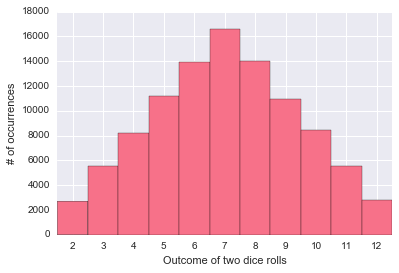

In [5]:
n, bins, patches = plt.hist(S.reshape(-1), bins=np.arange(2,14) - 0.5)
plt.xlim(2-.5,12+0.5)
plt.xticks(range(2,13))
plt.xlabel('Outcome of two dice rolls')
plt.ylabel('# of occurrences')

In [79]:
from numpy import sqrt,pi,vectorize,exp
from scipy.special import gamma
from scipy import stats

def plot_2d_pdf(pdf_func, X, Y, colors=None):
    Z = pdf_func(*np.meshgrid(X, Y))
    plt.contour(X, Y, Z, colors=colors)

    plt.xlabel("$\mu$")
    plt.ylabel("$\lambda$")

# pdf factory functions
def get_gamma_pdf(a, b):
    return vectorize(lambda x: b**a / gamma(a) * x**(a-1) * exp(-x*b))

def get_gaussian_pdf(mu, sigma):
    norm = stats.norm(mu, sigma)
    return vectorize(lambda x: norm.pdf(x))

def get_gaussian_gamma_pdf(mu, lamb, a, b):
    const = (b**a)*sqrt(lamb) / (gamma(a) * sqrt(2*pi))
    return vectorize(lambda x, tau: const * tau**(a-0.5) * exp(-b*tau - 0.5*lamb*tau*(x-mu)**2))

def get_vi_gaussian_gamma_pdf(mu, lamb, a, b):
    gamma_pdf = get_gamma_pdf(a, b)
    gaussian_pdf = get_gaussian_pdf(mu, 1./lamb)
    return vectorize(lambda x, tau: gaussian_pdf(x) * gamma_pdf(tau))

def normalGammaPdf(mu, lamb, muprior, kappa, alpha, beta):
    C = (beta ^ alpha * sqrt(kappa)) / (gamma(alpha) * sqrt(2*pi));
    p = C * (lamb**(alpha-1/2)) * (exp(-beta * lamb)) * (exp(-kappa/2* (lamb * (mu - muprior)**2)));
    return p

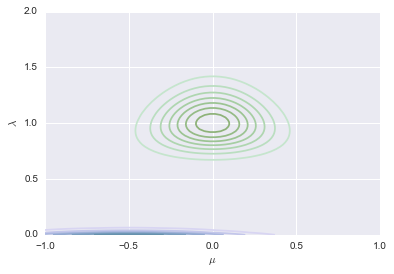

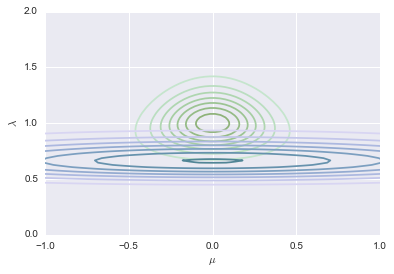

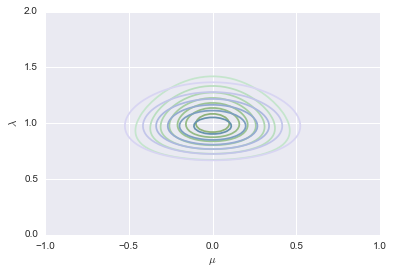

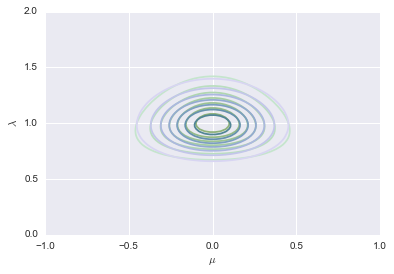

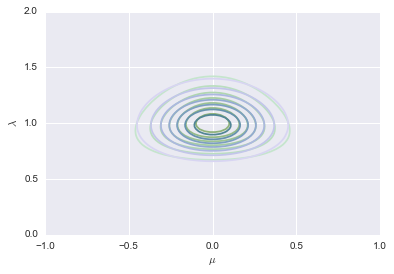

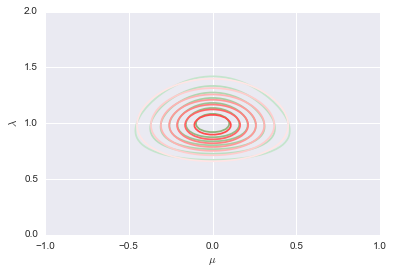

In [447]:
mu0 = 0.
var0 = 1

N = 20
X = np.random.normal(mu0, var0, N)
X = X - np.mean(X) # 0 mean
muX = np.mean(X)
varX = np.var(X)

# true posterior
a0 = 20
b0 = 20
k0 = 0
mu0 = 0

aNt = a0 + N/2.
bNt = b0 + 1./2*(N*varX + (k0*N*(muX - mu0)**2)/(k0 + N))
mut = (k0*mu0 + N*muX) / (k0 + N)
kNt = k0 + N
  
# initial guess
aN = 1.
bN = 30.
muN = -0.5
kN = 5.

for i in xrange(6):
    x = np.linspace(-1.5, +1.5, 100)
    y = np.linspace(0, 2., 100)

    cmap = sns.cubehelix_palette(20, start=10)
    plot_2d_pdf(get_gaussian_gamma_pdf(mut, kNt, aNt, bNt), x, y, cmap)
    cmap = sns.cubehelix_palette(12, start=2)
    if i == 5:
        cmap = sns.light_palette("red", 10)
    plot_2d_pdf(get_vi_gaussian_gamma_pdf(muN, np.sqrt(kN), aN, bN), x, y, cmap)

    plt.axis([-1,1,0,2])
    plt.show()
        
    muN = (k0 * mu0 + N * muX) / (k0 + N)
    precision = aN/bN
    kN = (k0 + N) * precision
    
    e_mu = muN
    e_mu2 = 1./kN + muN**2
    aN = a0 + (N + 1)/2.
    bN = b0 + k0 * (e_mu2 + mu0**2 - 2*e_mu*mu0) + 1./2 * np.sum(X**2 + e_mu2 - 2*e_mu*X)
    

In [448]:
def get_A():
    return np.asarray([[1./4, 3./4], [3./4, 1./4]])

def get_pi():
    return np.asarray([0.5, 0.5])

def get_B(p_dist, c_dist):
    B = np.zeros((2, 13))
    fair = Dice.get_fair_distribution()
    B[NORMAL,:] = np.insert(combine_distributions(p_dist, fair), 0, [0,0])
    B[PRIMED,:] = np.insert(combine_distributions(p_dist, c_dist), 0, [0,0])
    return B

def combine_distributions(d1, d2):
    dist = np.convolve(d1, d2)
    return dist

def get_alpha(O, A, B, pi):
    observation_length = len(O)
    nr_states = 2
    alpha = np.zeros(observation_length * nr_states).reshape(observation_length, nr_states)
    C = [0.] * observation_length
    for i in range(nr_states):
        alpha[0,i] = pi[i] * B[i, O[0]]
        C[0] += alpha[0,i]

    if C[0] != 0:
        C[0] = 1./C[0]
        
    for i in range(nr_states):
        alpha[0][i] *= C[0]
    
    for t in range(1, observation_length):
        C[t] = 0
        for i in range(nr_states):
            alpha[t][i] = 0
            for j in range(nr_states):
                alpha[t,i] += alpha[t-1,j] * A[j,i]

            alpha[t,i] *= B[i, O[t]]
            C[t] += alpha[t,i]

        if C[t] != 0:
            C[t] = 1./C[t]
        
        for i in range(nr_states):
            alpha[t,i] *= C[t]
    return alpha

In [439]:
def sample_from_posterior(O, p_loaded, c_loaded):
    A = get_A()
    B = get_B(p_loaded, c_loaded)
    pi = get_pi()
    alpha = get_alpha(O, A, B, pi)

    nr_states = len(A)
    nr_observations = len(O)

    evidence = 0
    for i in range(nr_states):
        evidence += alpha[-1][i]
        
    p0 = alpha[-1][0] / evidence
    rk = np.random.binomial(1,p0)
    stateSequence = []
    for i in reversed(range(nr_observations-1)):
        rkPrev = []
        for previous in range(nr_states):
            rkPrev.append(A[previous][rk]*alpha[i][previous])
        factor = 0
        for i in range(nr_states):
            factor += rkPrev[i]
        probRkPrev = rkPrev[1]/factor
        stateSequence.append(np.random.binomial(1,probRkPrev))

    stateSequence = stateSequence[::-1]
    stateSequence.append(rk)
    return stateSequence

In [440]:
from scipy import stats

p_dist = Dice.get_fair_distribution()#5 * [1./10] + [5./10]
# p_dist = 5 * [1./10] + [5./10]
c_dist = [4./10] + [2. / 10] * 3 + [0] + [0]

K = 100
N = 100

casino = Casino(K, primed_table_dice_distribution=c_dist)
players = []
dice = Dice(p_dist)

for _ in xrange(N):
    players.append(Player(casino, nr_tables_to_visit=K, dice=dice))

S = np.zeros((N, K))
for n in xrange(N):
    Sn, Xn, Zn = players[n].walk_casino()
    S[n,:] = Sn

rolls = " & ".join("%1d" % r for r in S[0,:])
print 'rolls: %s' % rolls

actual = map(lambda r: 1 if players[0].casino.is_table_primed(r) else 0, players[0].visited_tables)
print 'actual: %s' % " & ".join("%1d" % r for r in actual)

samples = []
for i in xrange(len(S)):
    samples.append(sample_from_posterior(S[i], p_dist, casino.primed_table_dice_distribution))

print 'guess: %s' % " & ".join("%1d" % x for x in stats.mode(samples)[0][0])

sample0 = stats.mode(samples)[0][0]
result = actual == sample0
print result
print np.sum(result)

rolls: 4 & 4 & 7 & 5 & 5 & 2 & 5 & 7 & 9 & 8 & 8 & 6 & 6 & 7 & 5 & 5 & 5 & 4 & 2 & 4 & 7 & 7 & 2 & 8 & 4 & 9 & 4 & 6 & 9 & 4 & 7 & 5 & 10 & 3 & 6 & 10 & 5 & 5 & 9 & 9 & 2 & 8 & 7 & 9 & 7 & 2 & 4 & 6 & 6 & 3 & 5 & 6 & 5 & 7 & 5 & 9 & 5 & 6 & 9 & 5 & 9 & 7 & 8 & 7 & 10 & 6 & 7 & 7 & 5 & 6 & 9 & 4 & 10 & 5 & 4 & 9 & 3 & 6 & 6 & 3 & 9 & 3 & 5 & 7 & 7 & 7 & 7 & 3 & 7 & 3 & 4 & 7 & 8 & 7 & 6 & 7 & 2 & 6 & 5 & 4
actual: 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1


TypeError: get_alpha() takes exactly 3 arguments (4 given)

In [441]:
def ind(a,b,c):
    return 1 if a + b == c else 0

def compute_expectation(alpha, phi, k, n, m, l, s):
    nominator = alpha[k,l] * phi[n,m] * ind(l,m,s)

    if nominator == 0: return 0
    
    denominator = 0;
    for i, j in product(range(6), range(6)):
        denominator += alpha[k,i] * phi[n,j] * ind(i,j,s)

    return nominator/denominator

In [442]:
def get_alpha(prev_alpha, prev_phi, S):
    alpha = np.zeros((K,6))
    for k, j in product(range(K), range(6)):
        numerator = 0.
        for n, m in product(range(N), range(6)):
            numerator += compute_expectation(prev_alpha, prev_phi, k, n, m, j, S[n,k])
        denominator = 0.
        for l, n, m in product(range(6), range(N), range(6)):
            denominator += compute_expectation(prev_alpha, prev_phi, k, n, m, l, S[n,k])
        alpha[k,j] = numerator/denominator
    return alpha

def get_phi(prev_alpha, prev_phi, S):
    phi = np.zeros((N,6))
    for n, i in product(range(N), range(6)):
        numerator = 0.
        for k, l in product(range(K), range(6)):
            numerator += compute_expectation(prev_alpha, prev_phi, k, n, i, l, S[n,k])
        denominator = 0.
        for m, k, l in product(range(6), range(K), range(6)):
            denominator += compute_expectation(prev_alpha, prev_phi, k, n, m, l, S[n,k])
        phi[n,i] = numerator/denominator
    return phi

ans: -30562.1533327
ans: -31257.7928557
ans: -31427.13908


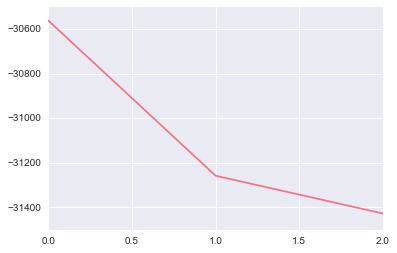

In [443]:
prev_alpha = np.random.dirichlet(np.ones(6),size=K)
prev_phi = np.random.dirichlet(np.ones(6),size=N)

iterations = 100
Q = []
epsilon = 1e-9
tolerance = 1e-6

S_indexed = S - 2

for i in range(iterations):
    Q.append(0)
    alpha = get_alpha(prev_alpha, prev_phi, S_indexed)
    phi = get_phi(prev_alpha, prev_phi, S_indexed)
    for n, k, l, m in product(range(N), range(K), range(6), range(6)):
        e = compute_expectation(prev_alpha, prev_phi, k, n , m, l, S_indexed[n,k])
        Q[i] += e * (np.log(alpha[k,l] + epsilon) + np.log(phi[n,m] + epsilon))

    print 'ans: %s' % Q[i]
    if i > 1 and tolerance > abs(Q[i-1]) - abs(Q[i]):
        break
        
    prev_alpha = alpha
    prev_phi = phi


plt.plot(np.arange(len(Q)),Q[:len(Q)])
plt.show()    

In [444]:
print np.average(alpha, axis=0)
print np.average(phi, axis=0)

[ 0.25891718  0.22111528  0.18551796  0.15283911  0.11469517  0.06691529]
[ 0.24741067  0.21786478  0.19567095  0.17257096  0.10975841  0.05672422]


In [445]:

# print 'actual: %s' % actual
# for a in alpha:
# print 'alpha: %s' % alpha
# print c_loaded

# print 'phi: %s' % phi
alpha_save = alpha
phi_save = phi
# print p_dist
print np.average(alpha_save, axis=0)
print np.average(phi_save, axis=0)

[ 0.25891718  0.22111528  0.18551796  0.15283911  0.11469517  0.06691529]
[ 0.24741067  0.21786478  0.19567095  0.17257096  0.10975841  0.05672422]


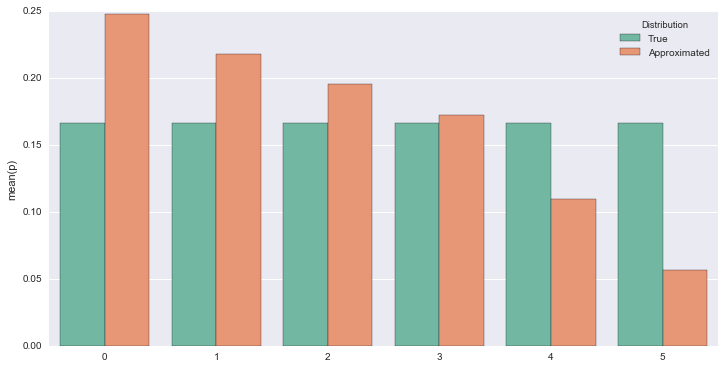

In [446]:
import pandas as pd

plt.figure(figsize=(12,6))

cd = [{'p': p, 'Distribution': 'True'} for p in p_dist]
ad = [{'p': p, 'Distribution': 'Approximated'} for p in np.average(phi, axis=0)]
pdf = pd.DataFrame(cd)
adf = pd.DataFrame(ad)
data = pdf.append(adf)

sns.barplot(x=data.index, y="p", data=data, hue="Distribution", palette="Set2")